In [335]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from skimage import feature
import joblib

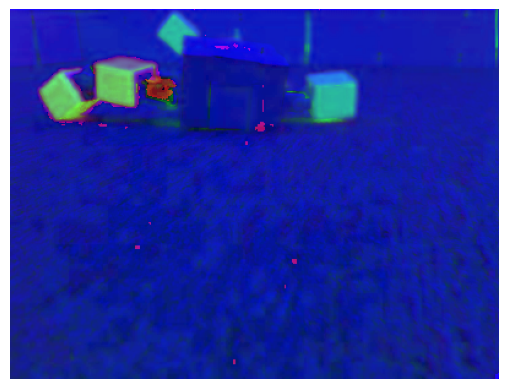

In [336]:
image = cv2.imread('image2.jpg')
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
plt.imshow(image_hsv)
plt.axis('off')
plt.show()

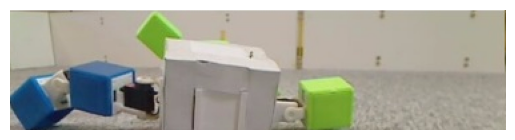

In [337]:
def segment_image(image, n_clusters=5):
    """Segment the image into n clusters using KMeans clustering."""
    pixels = image.reshape(-1, 3)
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(pixels)
    segmented_img = kmeans.labels_.reshape(image.shape[:2])
    return segmented_img, kmeans.cluster_centers_

def calculate_distance_matrix(centroids):
    """Calculate the distance matrix between centroids."""
    return cdist(centroids, centroids)

def find_center(centroids, distance_matrix):
    """Find the center region based on the distance matrix."""
    Dcenter = np.sum(distance_matrix, axis=1).mean()
    Di = np.sum(np.sort(distance_matrix, axis=1)[:, :2], axis=1)
    center_index = np.argmax(Di > Dcenter)
    return center_index, Di

def calculate_hm(segmented_img, center_index):
    """Calculate hm (heuristic measure) for the center region."""
    center_mask = segmented_img == center_index
    hm = np.sum(center_mask)
    return hm

def find_rois(segmented_img, centroids, center_index, hm, A=1):
    """Find ROIs based on the center region and heuristic measure."""
    rois = []
    regions = np.unique(segmented_img)
    for region in regions:
        if region == center_index:
            continue
        region_mask = segmented_img == region
        region_size = np.sum(region_mask)
        if region_size < A * hm:
            y, x = np.where(region_mask)
            minx, miny, maxx, maxy = x.min(), y.min(), x.max(), y.max()
            rois.append((minx, miny, maxx, maxy))
    return rois

def display_rois(image, rois):
    """Display the cropped ROIs."""
    S = []
    for roi in rois:
        minx, miny, maxx, maxy = roi
        S.append((minx-maxx) * (miny-maxy))
    
    min_area_index = S.index(min(S))
    minx, miny, maxx, maxy = rois[min_area_index]

    cropped_image = cv2.cvtColor(image[miny:maxy, minx:maxx], cv2.COLOR_HSV2RGB)
    plt.imshow(cropped_image)
    plt.axis('off')
    plt.show()
    return cropped_image

def main(image):
    segmented_img, centroids = segment_image(image)
    distance_matrix = calculate_distance_matrix(centroids)
    center_index, Di = find_center(centroids, distance_matrix)
    hm = calculate_hm(segmented_img, center_index)
    rois = find_rois(segmented_img, centroids, center_index, hm)
    return display_rois(image, rois)

cropped_image = main(image_hsv)
plt.imshow(cropped_image)




In [338]:
# Функція для обчислення HOG ознак
def compute_hog(image):
    hog_descriptor = feature.hog(image,
                                 orientations=9,
                                 pixels_per_cell=(8, 8),
                                 cells_per_block=(2, 2),
                                 block_norm='L2-Hys',
                                 transform_sqrt=True)
    return hog_descriptor

classifier = joblib.load('svm_hog_multi_class_model.pkl')
new_image = cv2.cvtColor(cropped_image, cv2.IMREAD_GRAYSCALE)

new_image = cv2.resize(new_image, (112, 32))
new_image_hog = compute_hog(new_image).reshape(1, -1)

prediction = classifier.predict(new_image_hog)
print(f'Предбачений клас зображення: {prediction[0]}')


C:\Users\opana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.5.0 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


ValueError: Only images with two spatial dimensions are supported. If using with color/multichannel images, specify `channel_axis`.